In [3]:
import torch
from transformers import AutoTokenizer, AutoModel
from pathlib import Path
from einops import rearrange, repeat
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [4]:
num_hidden_layers = 40
layers_arr = np.arange(num_hidden_layers)

So in code I would take each weight like v1 = lr_reporter.linear.weight  or something and v2 = vinc_reporter.weight, and then v1 /= np.linalg.norm(v1), v2 /= np.linalg.norm(v2) and finally cosine_sim = v1.T @ v2

In [5]:
def load_and_stack_layers(num_layers: int, reporter_type: 'str', prefix_path: str) -> torch.Tensor:
    layers = []
    if reporter_type == 'lr' or reporter_type == 'lr2':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = torch.load(layer_path)
            layers.append(layer.linear.weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked
    elif reporter_type == 'vinc':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = torch.load(layer_path)
            layers.append(layer.weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked
    elif reporter_type == 'ccs':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = torch.load(layer_path)
            layers.append(layer.probe[0].weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked

def get_norm_weights(data: dict, dataset: str, ccs_path: str, vinc_path: str, lr_path: str, lr2_path: str):
    
    for reporter,path in zip(['ccs','vinc','lr','lr2'], [ccs_path,vinc_path,lr_path, lr2_path]):
        weights = load_and_stack_layers(num_hidden_layers, reporter, path)
        magnitude = torch.norm(weights, dim=-1, keepdim=True)
        data[(dataset, reporter)] = weights/magnitude
    
    return data

def similarity(rep1_normalized: str, rep2_normalized: str):
    cosine_sim = torch.einsum("ij,ij->i", rep1_normalized, rep2_normalized)
    return cosine_sim

In [6]:
data = {}
dataset = 'imdb_misspelled_10'

lr_path = '/home/waree/elk-reporters/huggyllama/llama-13b/sethapun/imdb_misspelled_10/admiring-borg/lr_models'
ccs_path = '/home/waree/elk-reporters/huggyllama/llama-13b/sethapun/imdb_misspelled_10/admiring-borg/reporters'
vinc_path = '/home/waree/elk-reporters/huggyllama/llama-13b/sethapun/imdb_misspelled_10/magical-swartz/reporters'
lr2_path = '/home/waree/elk-reporters/huggyllama/llama-13b/sethapun/imdb_misspelled_10/magical-swartz/lr_models'

data = get_norm_weights(data, dataset, ccs_path, vinc_path, lr_path, lr2_path)


In [27]:
a = torch.tensor([[3,4],[5,12]], dtype=torch.float)
b = torch.norm(a, dim=-1, keepdim=True)
print(b)
print(a/b)

tensor([[ 5.],
        [13.]])
tensor([[0.6000, 0.8000],
        [0.3846, 0.9231]])


In [28]:
sim_lr1_lr2 = similarity(data[('imdb_misspelled_10','lr')], data[('imdb_misspelled_10','lr2')])
sim_lr1_ccs = similarity(data[('imdb_misspelled_10','lr')], data[('imdb_misspelled_10','ccs')])
sim_lr1_vinc = similarity(data[('imdb_misspelled_10','lr')], data[('imdb_misspelled_10','vinc')])

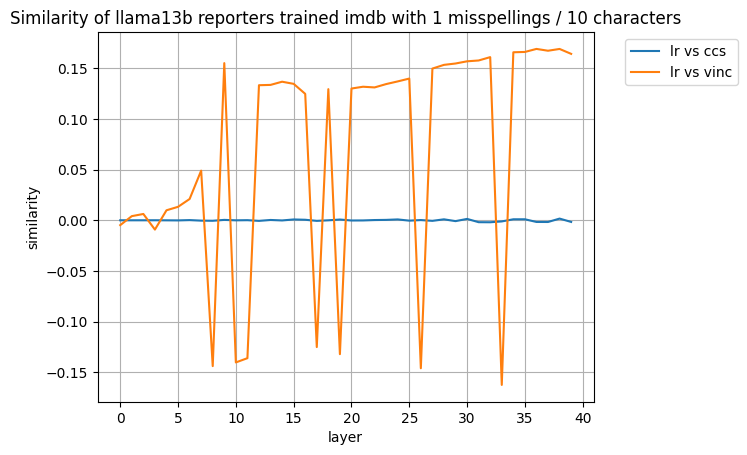

In [31]:
model = 'llama13b'

fig, ax = plt.subplots()
ax.set_title(fr"Similarity of {model} reporters trained imdb with 1 misspellings / 10 characters")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

# Set line colors and styles
# line_colors = ['black', 'blue', 'red', 'green', 'orange','purple', 'teal', 'pink', 'sage', 'grey']
# ccs_line_style = '--'
# lr_line_style = ':'
# zs_line_style = '-.'
    
#ax.plot(layers_arr,sim_lr1_lr2, label = "lr vs lr2")
ax.plot(layers_arr,sim_lr1_ccs, label = "lr vs ccs")
ax.plot(layers_arr,sim_lr1_vinc, label = "lr vs vinc")
                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
model = 'llama13b'

fig, ax = plt.subplots()
ax.set_title(fr"{model} trained and tested on imdb, similarity between LR and VINC")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

# Set line colors and styles
# line_colors = ['black', 'blue', 'red', 'green', 'orange','purple', 'teal', 'pink', 'sage', 'grey']
# ccs_line_style = '--'
# lr_line_style = ':'
# zs_line_style = '-.'
    
ax.plot(layers_arr,sim)

# experiment = data[(model, train_dataset, test_dataset, 'ccs')]
# layers = experiment['layer']
# acc = experiment['acc']
# ax.plot(layers, acc, label=f'CCS tested on {test_dataset}',
#             color=line_color, linestyle=ccs_line_style)

# if 'lm_acc' in experiment.columns:
#     lm_acc = experiment['lm_acc']
#     # Set line color and style for zero-shot dataset
#     ax.plot(layers, lm_acc, label='zero-shot language model output',
#             color=line_color, linestyle=zs_line_style)

# if 'lr_acc' in experiment.columns:
#     lr_acc = experiment['lr_acc']
#     # Set line color and style for logistic regression dataset
#     ax.plot(layers, lr_acc, label='logistic regression',
#             color=line_color, linestyle=lr_line_style)
                
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()